In [1]:
from mxnet import init
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import nd
from mxnet import autograd
from mxnet import image
import numpy as np
import pickle as p
import mxnet as mx
from time import time
import matplotlib.pyplot as plt
ctx = mx.gpu()

In [2]:
def transform_train(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=36, rand_crop=True, rand_mirror=True,mean=np.array([0.4914, 0.4822, 0.4465]), std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))

def transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]), std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))

def get_data(batch_size):
    cifar10_train = gluon.data.vision.CIFAR10(root='/home/sinyer/Python/data', train=True, transform=transform_train)
    cifar10_test = gluon.data.vision.CIFAR10(root='/home/sinyer/Python/data', train=False, transform=transform_test)
    train_data = gluon.data.DataLoader(cifar10_train, batch_size, shuffle=True)
    test_data = gluon.data.DataLoader(cifar10_test, batch_size, shuffle=False)
    return train_data, test_data

def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(data_iterator, net, ctx):
    acc = 0.
    for data, label in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        acc += accuracy(output, label)
    return acc / len(data_iterator)

class Residual(nn.Block):
    def __init__(self, channels, same_shape=True, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.same_shape = same_shape
        with self.name_scope():
            strides = 1 if same_shape else 2
            self.conv1 = nn.Conv2D(channels, kernel_size=3, padding=1, strides=strides)
            self.bn1 = nn.BatchNorm()
            self.conv2 = nn.Conv2D(channels, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm()
            if not same_shape:
                self.conv3 = nn.Conv2D(channels, kernel_size=1, strides=strides)
    def forward(self, x):
        out = nd.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if not self.same_shape:
            x = self.conv3(x)
        return nd.relu(out + x)

class ResNet(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(ResNet, self).__init__(**kwargs)
        with self.name_scope(): 
            b1 = nn.Conv2D(16, kernel_size=3, strides=1, padding=1)
            b2 = nn.Sequential()
            for _ in range(8):
                b2.add(Residual(16))
            b3 = nn.Sequential()
            b3.add(Residual(32, same_shape=False))
            for _ in range(7):
                b3.add(Residual(32))
            b4 = nn.Sequential()
            b4.add(Residual(64, same_shape=False))
            for _ in range(7):
                b4.add(Residual(64))
            b5 = nn.Sequential()
            b5.add(nn.AvgPool2D(pool_size=3),nn.Dense(num_classes))
            self.net = nn.Sequential()
            self.net.add(b1, b2, b3, b4, b5)
    def forward(self, x):
        out = x
        for i, b in enumerate(self.net):
            out = b(out)
        return out

In [3]:
train_data, test_data = get_data(128)

In [4]:
net = ResNet(10)
net.initialize(ctx=ctx, init=init.Xavier())
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.05, 'momentum': 0.9, 'wd': 5e-4})

Epoch 0, Loss: 2.140522, Train acc 0.252514, Test acc 0.379549, Time 67.476280
Epoch 10, Loss: 0.604110, Train acc 0.790329, Test acc 0.766515, Time 68.015641
Epoch 20, Loss: 0.442042, Train acc 0.847618, Test acc 0.829312, Time 67.428057
Epoch 30, Loss: 0.375603, Train acc 0.871619, Test acc 0.822686, Time 67.421067
Epoch 40, Loss: 0.344340, Train acc 0.880079, Test acc 0.785997, Time 67.163018
Epoch 50, Loss: 0.327676, Train acc 0.886649, Test acc 0.795293, Time 65.704918
Epoch 60, Loss: 0.209623, Train acc 0.928453, Test acc 0.894086, Time 67.146435
Epoch 70, Loss: 0.073607, Train acc 0.974988, Test acc 0.901206, Time 68.860647
Epoch 80, Loss: 0.046907, Train acc 0.984583, Test acc 0.899723, Time 67.047877
Epoch 90, Loss: 0.038162, Train acc 0.986865, Test acc 0.894976, Time 68.534761
Epoch 100, Loss: 0.039130, Train acc 0.986573, Test acc 0.900119, Time 67.783846
Epoch 110, Loss: 0.047420, Train acc 0.983436, Test acc 0.892009, Time 67.359987
Epoch 120, Loss: 0.029649, Train acc 0.

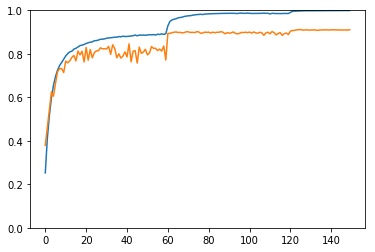

In [5]:
epochs = 150
lr_period = 60
lr_decay = 0.1

a = []
b = []
for epoch in range(epochs):
    if epoch > 0 and epoch % lr_period == 0:
        trainer.set_learning_rate(trainer.learning_rate * lr_decay)
    train_loss = 0.
    train_acc = 0.
    batch = 0
    start = time()
    for data, label in train_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            L = loss(output, label)
        L.backward()
        trainer.step(data.shape[0])
        train_loss += nd.mean(L).asscalar()
        train_acc += accuracy(output, label)
        batch += 1
    a.append(train_acc/batch)
    test_acc = evaluate_accuracy(test_data, net, ctx)
    b.append(test_acc)
    if epoch%10 == 0:
        print("Epoch %d, Loss: %f, Train acc %f, Test acc %f, Time %f" % (epoch, train_loss/batch, train_acc/batch, test_acc, time() - start))
plt.plot(np.arange(0, epochs),a,np.arange(0, epochs),b)
plt.ylim(0, 1)
plt.show()